In [12]:
%load_ext autoreload
%autoreload 2
import json
from scipy import sparse
from scipy import stats
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import string
from sys import getsizeof
import random
import sys
import os
import getopt
import xml.etree.ElementTree as xmltree
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Convert docs to TREC format, remove everything except text

In [3]:
dir_list = ["/home/muntean/clef-corpora/promise/ims/experimental-collections/CLEF/corpora/ATS1994", 
            "/home/muntean/clef-corpora/promise/ims/experimental-collections/CLEF/corpora/ATS1995", 
            "/home/muntean/clef-corpora/promise/ims/experimental-collections/CLEF/corpora/LEMONDE1994",
            "/home/muntean/clef-corpora/promise/ims/experimental-collections/CLEF/corpora/LEMONDE1995"]

In [4]:
def merge_file_in_dir(dirName, fout, docno2TextDict, fileType="ATS"):
    i=0
    for filename in os.listdir(dirName):
        xml_data = xmltree.parse(dirName + "/" + filename)
        i += 1
        root = xml_data.getroot()
        trecdoc = u"<DOC>\n"
        docno = ""
        text = ""
        for child in root:

            if child.tag == "DOCNO":
                trecdoc += u"<DOCNO>{}</DOCNO>\n".format(child.text)
                docno = child.text
            if fileType == "ATS" and child.tag in ["LD", "TX", "ST", "TB", "AU"]:
                trecdoc += u"{}\n".format(child.text)
                text += child.text.replace("\n", " ")
            if fileType == "LEMON" and child.tag in ["TEXT", "CHA1", "NOTE", "ORI1"]: 
                #LEAD1 - subtitle
                trecdoc += u"{}\n".format(child.text)
                if child.text is not None:
                    text += child.text
        trecdoc += u"</DOC>\n"
        fout.write(trecdoc)
        docno2TextDict[docno] = text
    
        if i % 10000 == 0:
            print("Number of docs in file {} : {}".format(filename, i))
    return docno2TextDict

In [5]:
### The parsing works aproximately, some docs are left out - TO REDO

docno2TextDict = dict()
with open("/home/muntean/CLEF-Adhoc-topics-pools/clef_FR_docs.trec", 'w') as fout:
    fout.write("<TRECDOCs>" + "\n")
    for path in dir_list:
        if "ATS" in path:
            docno2TextDict = merge_file_in_dir(path, fout, docno2TextDict, "ATS")
        else:
            docno2TextDict = merge_file_in_dir(path, fout, docno2TextDict, "LEMON")
    fout.write("</TRECDOCs>" + "\n")
    print(len(docno2TextDict))

Number of docs in file ATS.940203.0119.xml : 10000
Number of docs in file ATS.940106.0055.xml : 20000
Number of docs in file ATS.940318.0134.xml : 30000
Number of docs in file ATS.941117.0006.xml : 40000
Number of docs in file ATS.950829.0086.xml : 10000
Number of docs in file ATS.951115.0129.xml : 20000
Number of docs in file ATS.951225.0011.xml : 30000
Number of docs in file ATS.951012.0001.xml : 40000
Number of docs in file LEMONDE94-001172-19940815.xml : 10000
Number of docs in file LEMONDE94-002018-19941216.xml : 20000
Number of docs in file LEMONDE94-000450-19940705.xml : 30000
Number of docs in file LEMONDE94-002112-19941118.xml : 40000
Number of docs in file LEMONDE95-016651.xml : 10000
Number of docs in file LEMONDE95-007956.xml : 20000
Number of docs in file LEMONDE95-001309.xml : 30000
Number of docs in file LEMONDE95-047522.xml : 40000
177452


In [100]:
%store docno2TextDict

Stored 'docno2TextDict' (dict)


# 2. Clean and format topics

In [6]:
def get_topic_dict_per_year(dirName, output):
    qidTopic = dict()
    with open(output, "w") as outputFile:
        for filename in os.listdir(dirName):
            if "French" in filename and "MONO" in filename:
                print()
                print(filename)

                xml_data = xmltree.parse(dirName + "/" + filename)
                root = xml_data.getroot()
                for child in root:
                    if child[0].tag == "identifier":
                        qid = child[0].text.replace("-AH", "")
                    if child[1].tag == "title":
                        title = child[1].text.replace(".", "").replace("(", "").replace(")", "").replace(":", "")
#                         title = re.sub('[^0-9a-zA-Z ]+', '', child[1].text)
                    outputFile.write(qid+":"+title+"\n")
                    print(qid+":"+title)
                    qidTopic[qid] = title
    return qidTopic
               

In [14]:
qidTopic = {}
for year in range(2000,2007):
    dirName = "AH-CLEF"+str(year)
    qidTopicY = get_topic_dict_per_year("/home/muntean/CLEF-Adhoc-topics-pools/" + dirName + "/topics",
                           "/home/muntean/CLEF-Adhoc-topics-pools/clef-fr-"+
                            str(year)+"-title-queries.txt")
    qidTopic.update(qidTopicY)


French_topics_AH-MONO-FR-CLEF2000.xml
1:Architecture à Berlin
3:La drogue en Hollande
5:L'adhésion à l'Union Européenne
6:Objecteurs de conscience français
7:Dopage et football
8:Le suicide de Pierre Bérégovoy
9:Gisements de méthane
10:Guerre et radio
11:Une nouvelle constitution pour l'Afrique du Sud
12:Temple solaire
13:Conférence sur le contrôle des naissances au Caire
15:Compétitivité de l'industrie européenne
16:L'Académie Française
17:Feux de brousse près de Sydney
18:Accidents chez les pompiers
19:Le syndrome de la guerre du Golfe
20:La monnaie unique européenne
21:L'Espace Economique Européen
22:Accidents d'avions sur la piste
23:Grossesses post-ménopausiques
24:Organisation Mondiale du Commerce
25:Corruption en Italie
26:L'utilisation de la force éolienne
29:Le Prix Nobel d'économie
30:Effondrement du plafond d'un supermarché à Nice
31:La protection des consommateurs dans l'UE
32:Femmes prêtres
33:Tumeurs et génétique
34:Consommation d'alcool en Europe
35:Loups en Italie
37:N

# 3. Distrib, media, varianza di lunghezze - simple tokenization


### lunghezza media in Terrier
 index.meta.entry-length=121
 index.meta.entries=177452

## 3.1. Titles

333
DescribeResult(nobs=333, minmax=(1, 7), mean=2.828828828828829, variance=0.7868772386844676, skewness=0.8333186949453206, kurtosis=1.6099776610805883)
DescribeResult(nobs=333, minmax=(1, 12), mean=4.5225225225225225, variance=2.8767502442201245, skewness=0.5770334937878648, kurtosis=0.6979881833629471)


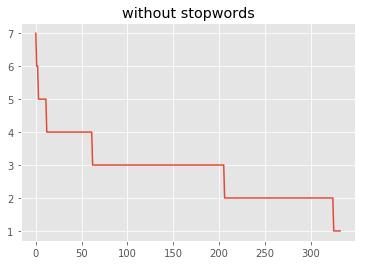

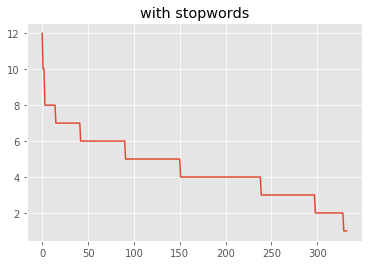

In [19]:
# load stopwords
stopwords = []
with open("/home/muntean//terrier-core-4.2/share/fr_sl.txt") as f:
    for line in f:
        stopwords.append(line.replace("\n",""))
# print(stopwords)
#stopwords = []
topic_len = []
for k,v in qidTopic.items():
    i = 0 
    j = 0
    for w in v.lower().split():
        if w not in stopwords:
            i+=1
        j+=1
    topic_len.append((i,j))
print(len(topic_len))
# print(topic_len)

x = [x for x,y in topic_len]
y = [y for x,y in topic_len]
print(stats.describe(x))
print(stats.describe(y))


plt.style.use("ggplot")

plt.plot(sorted(x, reverse=True))
plt.title("without stopwords")
plt.show()

plt.plot(sorted(y, reverse=True))
plt.title("with stopwords")
plt.show()

In [16]:
print (qidTopic)

{'1': 'Architecture à Berlin', '3': 'La drogue en Hollande', '5': "L'adhésion à l'Union Européenne", '6': 'Objecteurs de conscience français', '7': 'Dopage et football', '8': 'Le suicide de Pierre Bérégovoy', '9': 'Gisements de méthane', '10': 'Guerre et radio', '11': "Une nouvelle constitution pour l'Afrique du Sud", '12': 'Temple solaire', '13': 'Conférence sur le contrôle des naissances au Caire', '15': "Compétitivité de l'industrie européenne", '16': "L'Académie Française", '17': 'Feux de brousse près de Sydney', '18': 'Accidents chez les pompiers', '19': 'Le syndrome de la guerre du Golfe', '20': 'La monnaie unique européenne', '21': "L'Espace Economique Européen", '22': "Accidents d'avions sur la piste", '23': 'Grossesses post-ménopausiques', '24': 'Organisation Mondiale du Commerce', '25': 'Corruption en Italie', '26': "L'utilisation de la force éolienne", '29': "Le Prix Nobel d'économie", '30': "Effondrement du plafond d'un supermarché à Nice", '31': "La protection des consomma

## 3.2. Documents

In [9]:
doc_len = []
for k,v in docno2TextDict.items():
    i = 0 
    j = 0
    for w in v.lower().split():
        if w not in stopwords:
            i+=1
        j+=1
    doc_len.append((i,j))
print(len(doc_len))
# print(doc_len)

stats.describe(doc_len)

177452


DescribeResult(nobs=177452, minmax=(array([0, 0]), array([ 8199, 14702])), mean=array([201.40860627, 355.01887834]), variance=array([ 40601.80582119, 122243.56938398]), skewness=array([3.99020503, 3.38224273]), kurtosis=array([47.24913498, 38.63551877]))

In [10]:
x = [x for x,y in doc_len]
y = [y for x,y in doc_len]
print(stats.describe(x))
print(stats.describe(y))

DescribeResult(nobs=177452, minmax=(0, 8199), mean=201.40860627099158, variance=40601.80582119291, skewness=3.9902050271945497, kurtosis=47.249134984057655)
DescribeResult(nobs=177452, minmax=(0, 14702), mean=355.0188783445664, variance=122243.56938398513, skewness=3.3822427263516497, kurtosis=38.63551876791355)


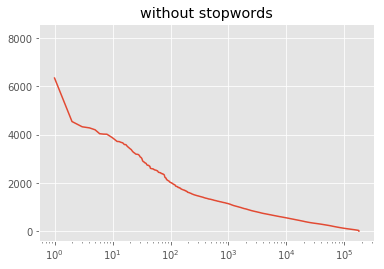

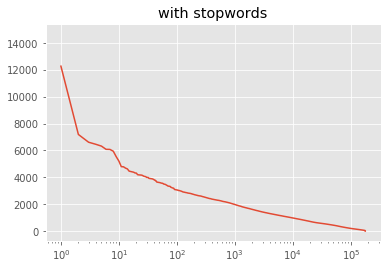

In [11]:
plt.semilogx(sorted(x, reverse=True))
plt.title("without stopwords")
plt.show()

plt.semilogx(sorted(y, reverse=True))
plt.title("with stopwords")
plt.show()